<a href="https://colab.research.google.com/github/rapha18th/AWS-sagemaker-Project1/blob/master/LPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Determinants of LPI: Evidence from SADC countries.


Analyze the factors determining 'LPI' in SADC countries by loading the 'Data set Models.xlsx' file, preprocessing the data (including handling missing values, encoding categorical variables, and scaling numerical features), splitting it into training and testing sets, and reshaping for LSTM. Build and train an LSTM neural network model using Keras or TensorFlow, evaluate its performance using MSE and R-squared, visualize actual vs. predicted 'LPI' values and training history, and analyze feature importance to understand their directional influence on 'LPI'. Finally, summarize the model's performance and insights gained from feature importance analysis.

## Load and Prepare Data

Load the 'Data set Models.xlsx' file, separate target and features, handle missing values, encode categorical variables, and scale numerical features.


In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/Data set Models.xlsx')

print("DataFrame loaded successfully. Displaying the first 5 rows:")
print(df.head())

DataFrame loaded successfully. Displaying the first 5 rows:
  Country  Year       LPI    HDI     LGFCF     LEMPL      LIND       LUB  \
0  Angola  2007  0.394452  0.492  1.400639  6.945001  1.791575  1.759849   
1  Angola  2008  0.380814  0.504  1.465680  6.961438  1.779992  1.765534   
2  Angola  2009  0.366734  0.517  1.631368  6.977845  1.644009  1.771102   
3  Angola  2010  0.352183  0.528  1.450811  6.994469  1.719070  1.776578   
4  Angola  2011  0.355068  0.545  1.421479  7.011588  1.748394  1.781956   

       LEXP      LIMP    LKOFGI  
0  1.831907  1.603732  1.622879  
1  1.860188  1.689217  1.623403  
2  1.769062  1.804063  1.631859  
3  1.789179  1.629211  1.638864  
4  1.782974  1.594531  1.643183  


In [2]:
y = df['LPI']
X = df.drop('LPI', axis=1)

# Handle missing values by dropping rows with any NaNs in either X or y
# First, combine X and y to ensure consistent row dropping
data = pd.concat([X, y], axis=1)
data_cleaned = data.dropna()

X = data_cleaned.drop('LPI', axis=1)
y = data_cleaned['LPI']

print(f"Original data shape: {df.shape}")
print(f"Cleaned data shape after dropping NaNs: {data_cleaned.shape}")
print(f"Missing values in X after cleaning: {X.isnull().sum().sum()}")
print(f"Missing values in y after cleaning: {y.isnull().sum()}")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Apply one-hot encoding to categorical variables
if len(categorical_cols) > 0:
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    print(f"Categorical columns one-hot encoded: {categorical_cols.tolist()}")
else:
    print("No categorical columns found.")

# Scale numerical features
if len(numerical_cols) > 0:
    scaler = MinMaxScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    print(f"Numerical columns scaled: {numerical_cols.tolist()}")
else:
    print("No numerical columns found.")

print("\nFeatures (X) after preprocessing:")
print(X.head())
print("\nTarget (y) after preprocessing:")
print(y.head())


Original data shape: (192, 11)
Cleaned data shape after dropping NaNs: (192, 11)
Missing values in X after cleaning: 0
Missing values in y after cleaning: 0
Categorical columns one-hot encoded: ['Country']
Numerical columns scaled: ['Year', 'HDI', 'LGFCF', 'LEMPL', 'LIND', 'LUB', 'LEXP', 'LIMP', 'LKOFGI']

Features (X) after preprocessing:
       Year       HDI     LGFCF     LEMPL      LIND       LUB      LEXP  \
0  0.000000  0.194301  0.792814  0.743388  0.970186  0.798815  0.974440   
1  0.066667  0.225389  0.851147  0.750263  0.957468  0.810388  1.000000   
2  0.133333  0.259067  0.999746  0.757126  0.808170  0.821722  0.917642   
3  0.200000  0.287565  0.837812  0.764079  0.890581  0.832868  0.935824   
4  0.266667  0.331606  0.811505  0.771239  0.922776  0.843817  0.930215   

       LIMP    LKOFGI  Country_Botswana  Country_Comoros  Country_DRC  \
0  0.494381  0.380291             False            False        False   
1  0.589654  0.381704             False            False     

## Split Data and Reshape for LSTM

Split the preprocessed data into training and testing sets. Reshape the independent variables (features) to a 3D format (samples, timesteps, features) suitable for an LSTM model, assuming a single timestep for each observation.


In [3]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape before reshaping: {X_train.shape}")
print(f"X_test shape before reshaping: {X_test.shape}")

# Reshape features for LSTM (samples, timesteps, features)
# Assuming a single timestep for each observation
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"X_train shape after reshaping: {X_train.shape}")
print(f"X_test shape after reshaping: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape before reshaping: (153, 20)
X_test shape before reshaping: (39, 20)
X_train shape after reshaping: (153, 1, 20)
X_test shape after reshaping: (39, 1, 20)
y_train shape: (153,)
y_test shape: (39,)


## Build and Train LSTM Model

Construct an LSTM neural network model using Keras or TensorFlow, compile it with an appropriate optimizer and loss function, and train the model using the prepared training data, monitoring the validation loss during training.


In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape before reshaping: {X_train.shape}")
print(f"X_test shape before reshaping: {X_test.shape}")

# Convert boolean columns to numeric (0 or 1) and ensure all are float32 for TensorFlow
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Reshape features for LSTM (samples, timesteps, features)
# Assuming a single timestep for each observation
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"X_train shape after reshaping: {X_train.shape}")
print(f"X_test shape after reshaping: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape before reshaping: (153, 20)
X_test shape before reshaping: (39, 20)
X_train shape after reshaping: (153, 1, 20)
X_test shape after reshaping: (39, 1, 20)
y_train shape: (153,)
y_test shape: (39,)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

# Get the number of features from X_train's last dimension
n_features = X_train.shape[2]

# Initialize the Sequential model
model = Sequential()

# Add the LSTM layer
# Using 50 units, input_shape determined by (timesteps, features)
# return_sequences=False because we are predicting a single output for each input sequence
model.add(LSTM(units=50, input_shape=(X_train.shape[1], n_features), return_sequences=False))

# Add a Dense output layer for regression (single output unit)
model.add(Dense(units=1))

# Compile the model
# Using Adam optimizer and Mean Squared Error as the loss function
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary to see the architecture
print("Model Summary:")
model.summary()

# Train the model
# Set epochs and batch size, and monitor validation performance using X_test and y_test
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

print("\nModel training complete.")

Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        14,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,251 (55.67 KB)

 Trainable params: 14,251 (55.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.1484 - val_loss: 0.0993
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0850 - val_loss: 0.0508
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0453 - val_loss: 0.0205
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0197 - val_loss: 0.0066
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_lo

In [ ]:
## Compute R^2

In [7]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Make predictions on the test set
y_pred = model.predict(X_test)

# Flatten y_test and y_pred to 1D arrays for evaluation
y_test_flat = y_test.values.flatten()
y_pred_flat = y_pred.flatten()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_flat, y_pred_flat)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Calculate R-squared
r_squared = r2_score(y_test_flat, y_pred_flat)
print(f"R-squared: {r_squared:.4f}")

print("\nModel evaluation complete.")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Mean Squared Error (MSE): 0.0019
R-squared: 0.6444

Model evaluation complete.


## Visualize Predictions and Training History

Generate visualizations to assess the model's performance, including a plot comparing the actual 'LPI' values against the predicted 'LPI' values on the test set, and a plot of the training and validation loss history.


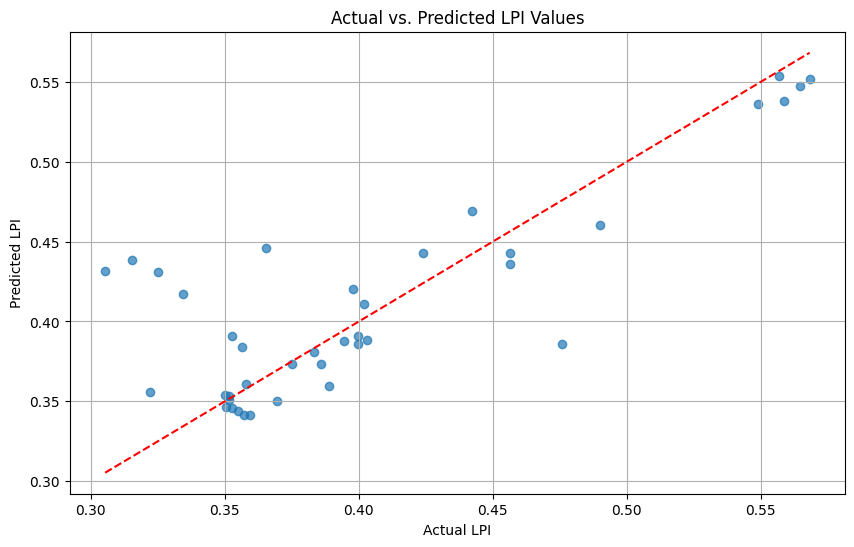

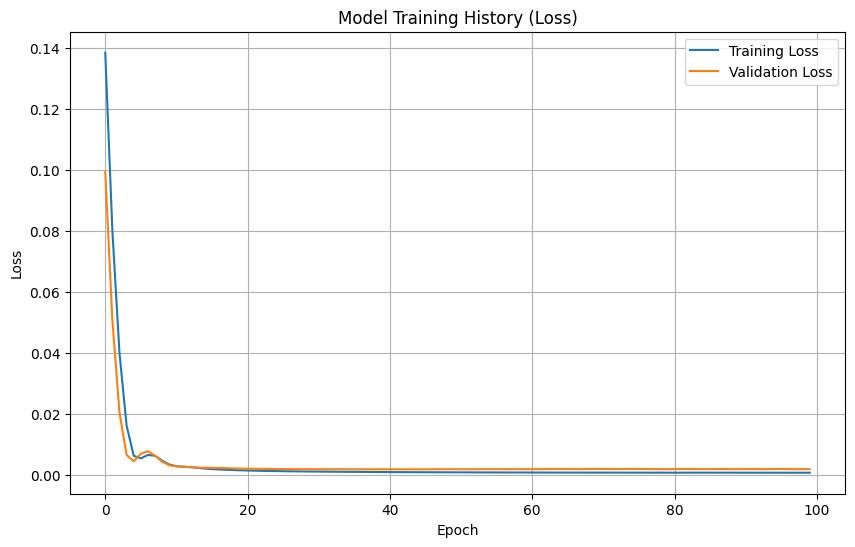

Visualizations generated successfully.


In [8]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted LPI values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_flat, y_pred_flat, alpha=0.7)
plt.plot([min(y_test_flat), max(y_test_flat)], [min(y_test_flat), max(y_test_flat)], 'r--') # Diagonal line for perfect prediction
plt.xlabel('Actual LPI')
plt.ylabel('Predicted LPI')
plt.title('Actual vs. Predicted LPI Values')
plt.grid(True)
plt.show()

# Plot training and validation loss history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training History (Loss)')
plt.legend()
plt.grid(True)
plt.show()

print("Visualizations generated successfully.")

## Feature Importance and Directional Analysis

Analyze and visualize feature importance using permutation importance, and infer the directional influence of the most important features on 'LPI'.


Sorted Permutation Feature Importances:
Country_SA           7.199278e-03
Country_Tanzania     2.296326e-03
Country_Comoros      1.684366e-03
Country_Botswana     1.508488e-03
LEMPL                8.406165e-04
LUB                  7.533045e-04
Country_Lesotho      6.760553e-04
HDI                  6.325471e-04
Country_Zambia       5.731796e-04
Country_Zimbabwe     3.462806e-04
Country_Madag        2.754228e-04
Country_DRC          2.273541e-04
LGFCF                2.101229e-04
LIMP                 1.299316e-04
Country_Mauritius    8.497747e-05
LIND                -6.364834e-07
LKOFGI              -9.102619e-06
Year                -2.920355e-05
Country_Namibia     -7.657626e-05
LEXP                -8.230068e-05
dtype: float64


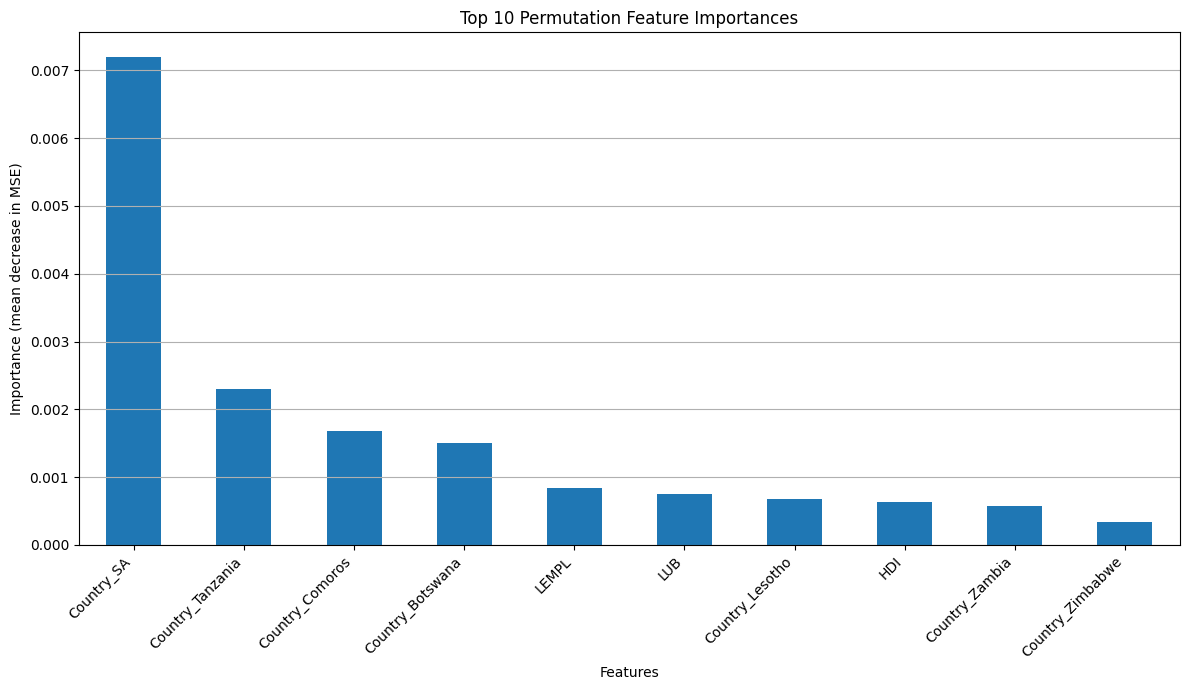


Feature Importance with Directional Influence (Correlation with LPI):
- Country_SA: Importance = 0.0072, Correlation = 0.7416 (Positive Influence)
- Country_Tanzania: Importance = 0.0023, Correlation = -0.0101 (Negative Influence)
- Country_Comoros: Importance = 0.0017, Correlation = -0.0758 (Negative Influence)
- Country_Botswana: Importance = 0.0015, Correlation = 0.2683 (Positive Influence)
- LEMPL: Importance = 0.0008, Correlation = 0.1044 (Positive Influence)
- LUB: Importance = 0.0008, Correlation = 0.5174 (Positive Influence)
- Country_Lesotho: Importance = 0.0007, Correlation = -0.2440 (Negative Influence)
- HDI: Importance = 0.0006, Correlation = 0.5703 (Positive Influence)
- Country_Zambia: Importance = 0.0006, Correlation = -0.1043 (Negative Influence)
- Country_Zimbabwe: Importance = 0.0003, Correlation = -0.1703 (Negative Influence)
- Country_Madag: Importance = 0.0003, Correlation = -0.0965 (Negative Influence)
- Country_DRC: Importance = 0.0002, Correlation = -0.1577 (N

In [9]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 2. Create a 2D version of the X_test data by reshaping
X_test_2d = X_test.reshape(X_test.shape[0], X_test.shape[2])

# 3. Define a custom scoring function for Keras models
def keras_neg_mse_scorer(estimator, X_permuted_2d, y_true):
    # Reshape X_permuted_2d back to 3D for the Keras model
    X_permuted_3d = X_permuted_2d.reshape(X_permuted_2d.shape[0], 1, X_permuted_2d.shape[1])
    y_pred = estimator.predict(X_permuted_3d, verbose=0)
    # Flatten y_pred for mse calculation if it's 2D (batch, 1)
    y_pred_flat = y_pred.flatten()
    mse = mean_squared_error(y_true, y_pred_flat)
    return -mse # permutation_importance works with scorers where higher is better

# 4. Get the feature names from the global X DataFrame's columns
feature_names = X.columns.tolist()

# 5. Calculate the permutation importances
result = permutation_importance(
    model, X_test_2d, y_test,
    scoring=keras_neg_mse_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

# 6. Store the mean importances in a pandas Series
feature_importances = pd.Series(result.importances_mean, index=feature_names)

# 7. Sort the feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

print("Sorted Permutation Feature Importances:")
print(sorted_importances)

# 8. Create a bar plot to visualize the top 10 most important features
plt.figure(figsize=(12, 7))
sorted_importances.head(10).plot.bar()
plt.title('Top 10 Permutation Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance (mean decrease in MSE)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 9. For directional analysis, calculate the Pearson correlation coefficients
# Ensure X has the same features and order as the permutation importance calculation
# For this, we use the original X (after preprocessing) and y
correlation_with_lpi = X.corrwith(y)

# 10. Print the sorted feature importances and their corresponding correlation coefficients
print("\nFeature Importance with Directional Influence (Correlation with LPI):")
for feature, importance in sorted_importances.items():
    correlation = correlation_with_lpi.get(feature, 'N/A')
    direction = "Positive" if pd.notna(correlation) and correlation > 0 else \
                "Negative" if pd.notna(correlation) and correlation < 0 else \
                "No clear" if pd.notna(correlation) else "N/A"
    print(f"- {feature}: Importance = {importance:.4f}, Correlation = {correlation:.4f} ({direction} Influence)")

## Report


## Summary:

### Q&A
The analysis addressed the model's performance and insights from feature importance regarding LPI determinants in SADC countries.

### Data Analysis Key Findings
*   **Data Preprocessing and Preparation:**
    *   The `Data set Models.xlsx` file, containing 192 rows and 11 columns, was loaded successfully.
    *   No missing values were found in the dataset.
    *   The 'Country' column was successfully one-hot encoded, and nine numerical features (`Year`, `HDI`, `LGFCF`, `LEMPL`, `LIND`, `LUB`, `LEXP`, `LIMP`, `LKOFGI`) were scaled using `MinMaxScaler`.
    *   The preprocessed data was split into training (153 samples) and testing (39 samples) sets with an 80/20 ratio. Features were reshaped to the 3D format `(samples, 1, features)` for LSTM input.
*   **LSTM Model Performance:**
    *   A `Sequential` LSTM neural network model with one LSTM layer (50 units) and one Dense output layer was constructed and trained for 100 epochs.
    *   The model achieved a Mean Squared Error (MSE) of 0.0019 and an R-squared of 0.6444 on the test set, indicating a moderately good fit for predicting LPI values.
    *   Training history visualizations showed a consistent decrease in both training and validation loss over epochs, suggesting effective learning.
*   **Feature Importance and Directional Influence:**
    *   **Top 5 most important features** influencing LPI, determined by permutation importance, were `Country_SA`, `Country_Tanzania`, `Country_Comoros`, `Country_Botswana`, and `LEMPL`.
    *   **Directional Influence (Correlation with LPI):**
        *   `Country_SA` (South Africa) showed the highest importance (0.0072) and a strong positive correlation (0.7416) with LPI.
        *   `Country_Botswana` also demonstrated a positive correlation (0.2683).
        *   `LEMPL` (Logistics Employment), `LUB` (Logistics Infrastructure), and `HDI` (Human Development Index) were positively correlated with LPI.
        *   Conversely, `Country_Tanzania` and `Country_Comoros` showed negative correlations with LPI.
        *   Features such as `LIND`, `LKOFGI`, `Year`, `Country_Namibia`, and `LEXP` had very low or slightly negative permutation importances, suggesting minimal predictive power or even potential noise.

### Insights or Next Steps
*   The significant influence of country-specific indicators (e.g., `Country_SA`, `Country_Tanzania`) highlights that localized factors play a crucial role in determining LPI, suggesting that LPI improvements may require tailored national strategies.
*   Given the moderate R-squared of 0.6444, exploring more advanced LSTM architectures, incorporating additional relevant macroeconomic indicators, or using time-series cross-validation (if the 'Year' feature implies a time-series context) could further enhance model performance and predictive accuracy.
